# Oxygen Isotope Tracer: Science

This notebook is for investigating the characteristics of the oxygen isotope tracer data, built in the "case_study" notebook on the Arctic Ocean Reanalysis

In [1]:
import yaml

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from netcdf_climate_analysis_funcs import climdata, multiplot, timeseriesplot, climatology, anomaly
from netcdf_climate_analysis_funcs.small_funcs import timeseg, weighted_average, timestep_da, merge_da, xy_region

from data_plotting import ArcticPlotter, OxygenIsotopePlots

with open("config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)

/noc/users/acable/miniforge3/envs/AISIT/lib/python3.13/site-packages/symfit/core/printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 1. Load the data

In [2]:
# Load oyxgen isotope & salinity data
oxy_iso = climdata(CONFIG["arctic_reanalysis_oxy"], var="oxygen_isotope_tracer")
sal = climdata(CONFIG["arctic_reanalysis"], var="so")

In [3]:
# Create climatology and anomaly
## d18O
oxy_iso_clim = climatology(oxy_iso, "month")
oxy_iso_anom = anomaly(oxy_iso, oxy_iso_clim, "month")
## Salinity
sal_clim = climatology(sal, "month")
sal_anom = anomaly(sal, sal_clim, "month")

In [4]:
# Create timeseries by computing weighted average over lat/lon
## d18O
oxy_iso_tseries = weighted_average(oxy_iso, "longitude", "latitude")
oxy_iso_clim_tseries = weighted_average(oxy_iso_clim, "longitude", "latitude")
oxy_iso_anom_tseries = weighted_average(oxy_iso_anom, "longitude", "latitude")
## Salinity
sal_tseries = weighted_average(sal, "longitude", "latitude")
sal_clim_tseries = weighted_average(sal_clim, "longitude", "latitude")
sal_anom_tseries = weighted_average(sal_anom, "longitude", "latitude")

In [5]:
# Load AOO data
aoo_df = pd.read_csv(CONFIG["aoo_index"], sep="|", index_col=0)
aoo_da = xr.DataArray(aoo_df["AOO Index"].values,coords={"time": pd.to_datetime(aoo_df["Year"], format="%Y")},dims="time",name="aoo_index")

## 2. Simple Plots

In [6]:
oxy_pos_aoo = timeseg(oxy_iso, "time", ("1994-01-01", "1994-12-01"))
oxy_neg_aoo = timeseg(oxy_iso, "time", ("2007-01-01", "2007-12-01"))
oxy_2019 = timeseg(oxy_iso, "time", ("2019-01-01", "2019-12-01"))

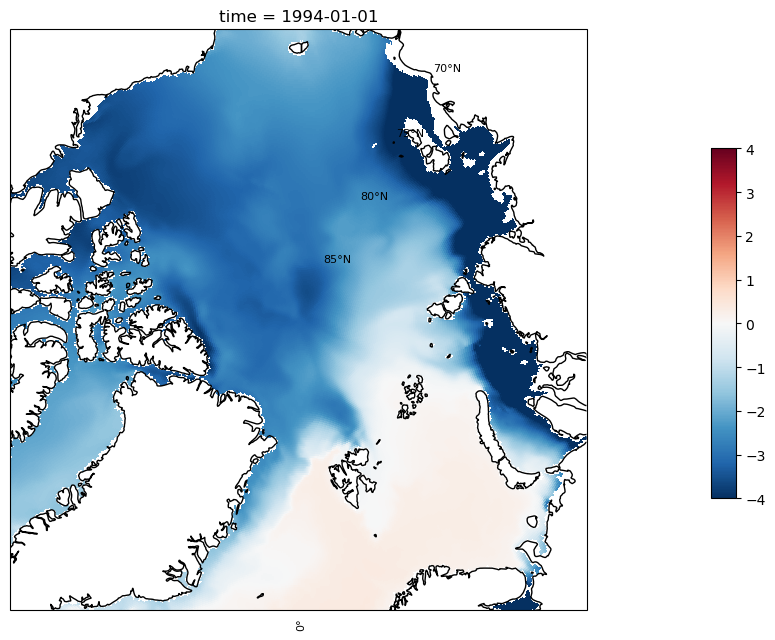

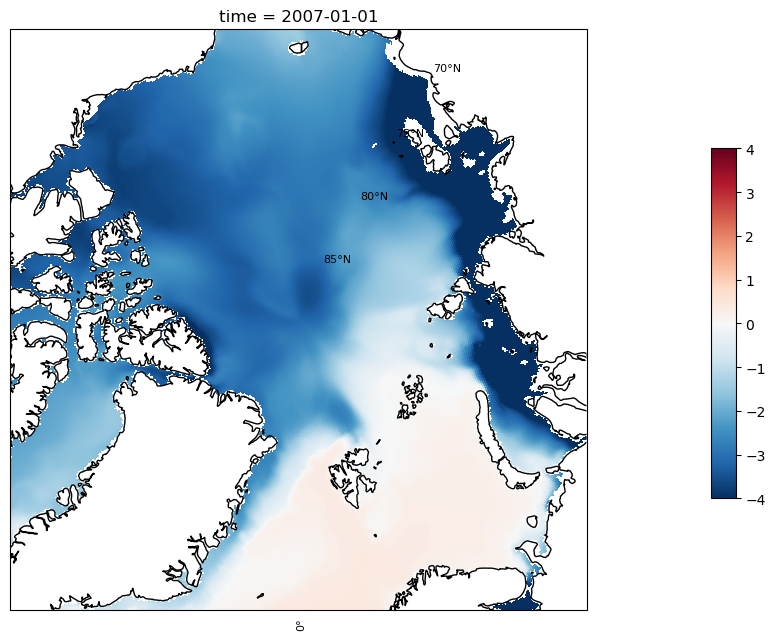

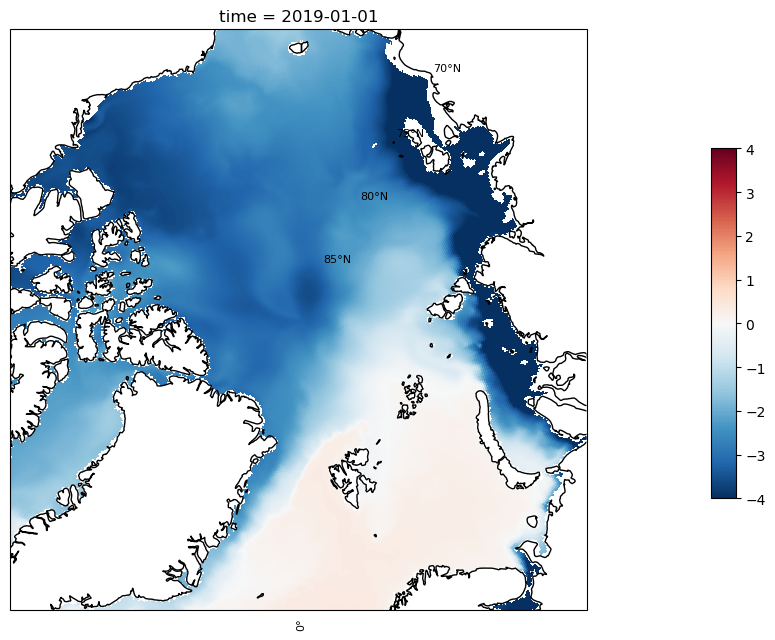

In [7]:
fig, ax, p = multiplot(oxy_pos_aoo.isel(time=0), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))
fig, ax, p = multiplot(oxy_neg_aoo.isel(time=0), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))
fig, ax, p = multiplot(oxy_2019.isel(time=0), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

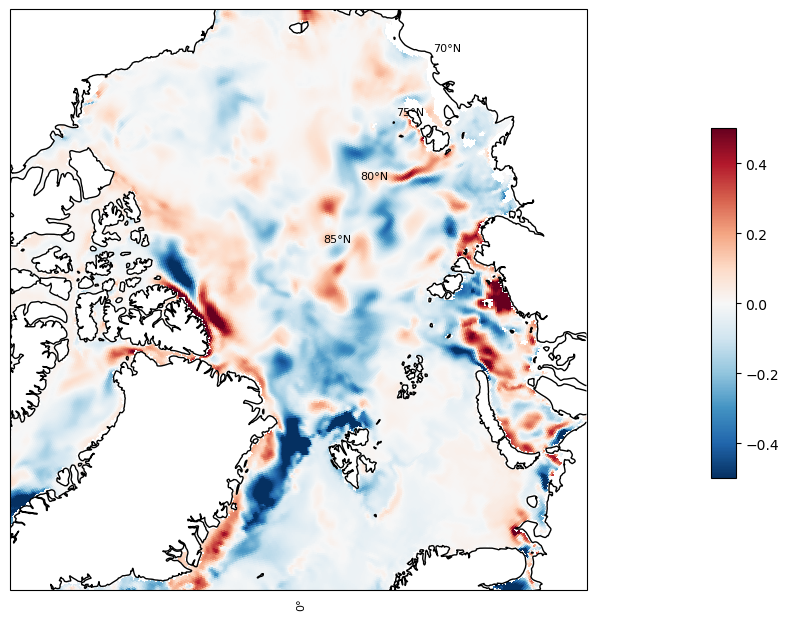

In [8]:
fig, ax, p = multiplot(oxy_pos_aoo.isel(time=0) - oxy_neg_aoo.isel(time=0), vmin=-.5, vmax=.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

(<Figure size 1500x700 with 1 Axes>,
 <Axes: xlabel='time', ylabel='oxygen isotope tracer anomaly'>,
 [<matplotlib.lines.Line2D at 0x7f7312075f90>])

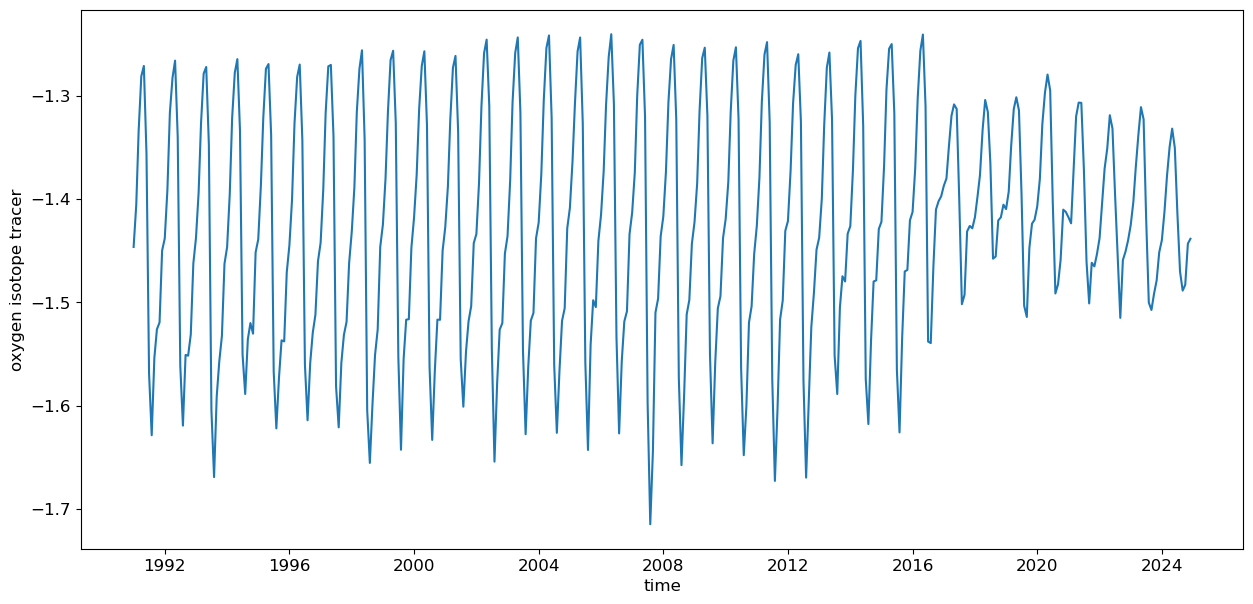

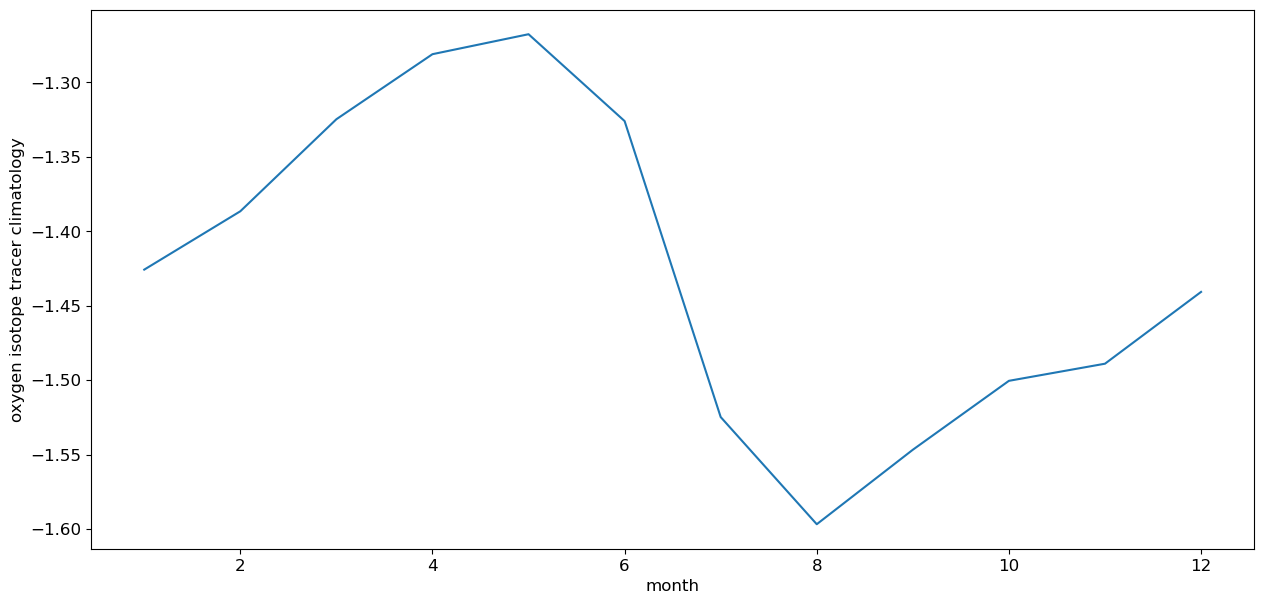

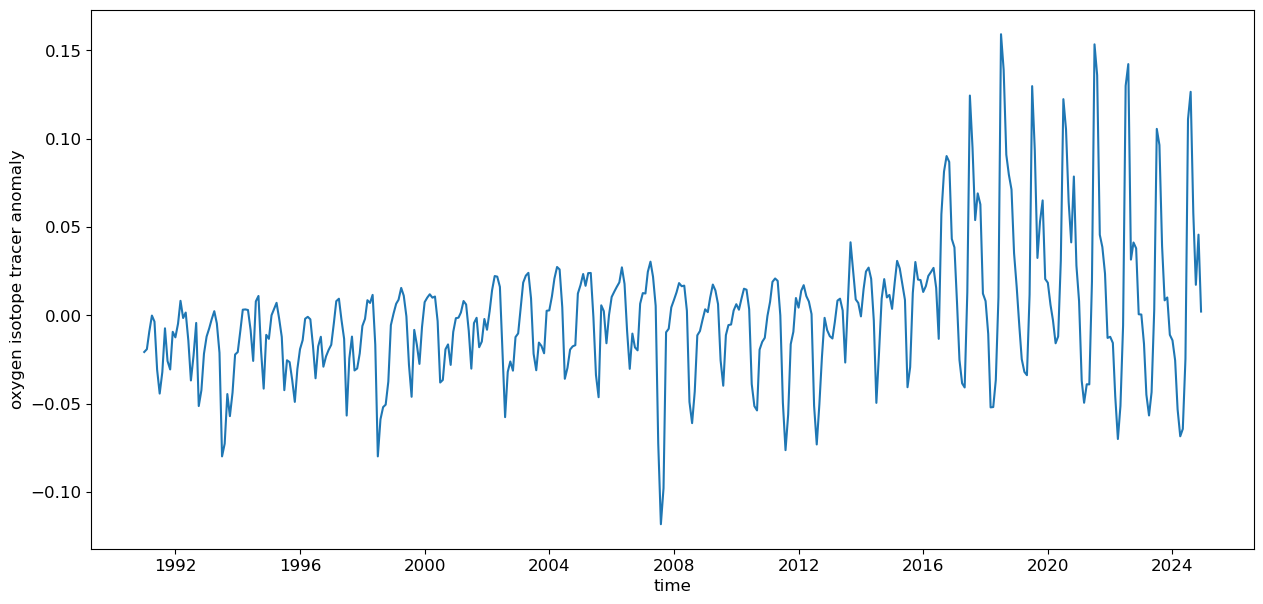

In [9]:

timeseriesplot(oxy_iso_tseries, "oxygen isotope tracer", "time")
timeseriesplot(oxy_iso_clim_tseries, "oxygen isotope tracer climatology", "month")
timeseriesplot(oxy_iso_anom_tseries, "oxygen isotope tracer anomaly", "time")

(<Figure size 1500x700 with 1 Axes>,
 <Axes: xlabel='time', ylabel='salinity anomaly'>,
 [<matplotlib.lines.Line2D at 0x7f7313bf3ed0>])

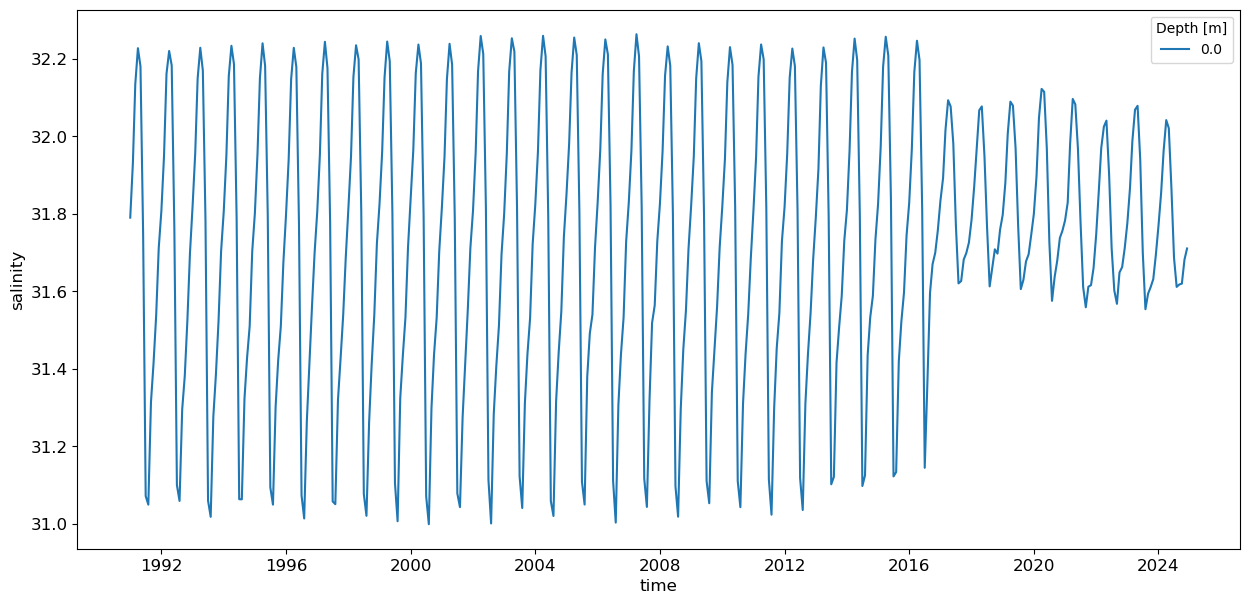

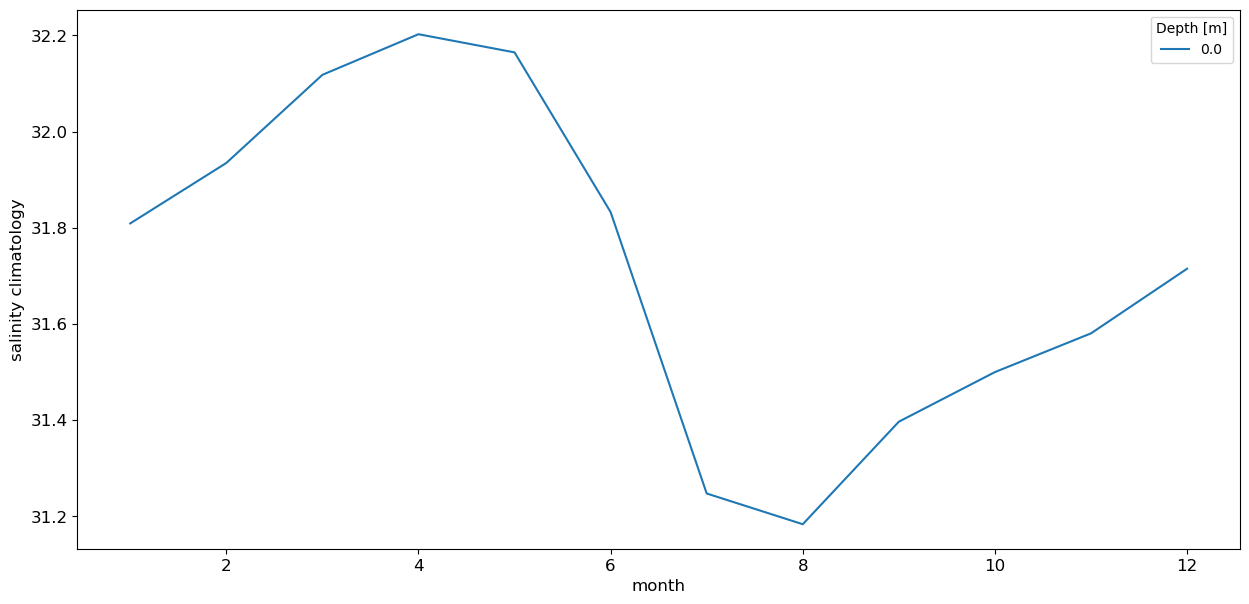

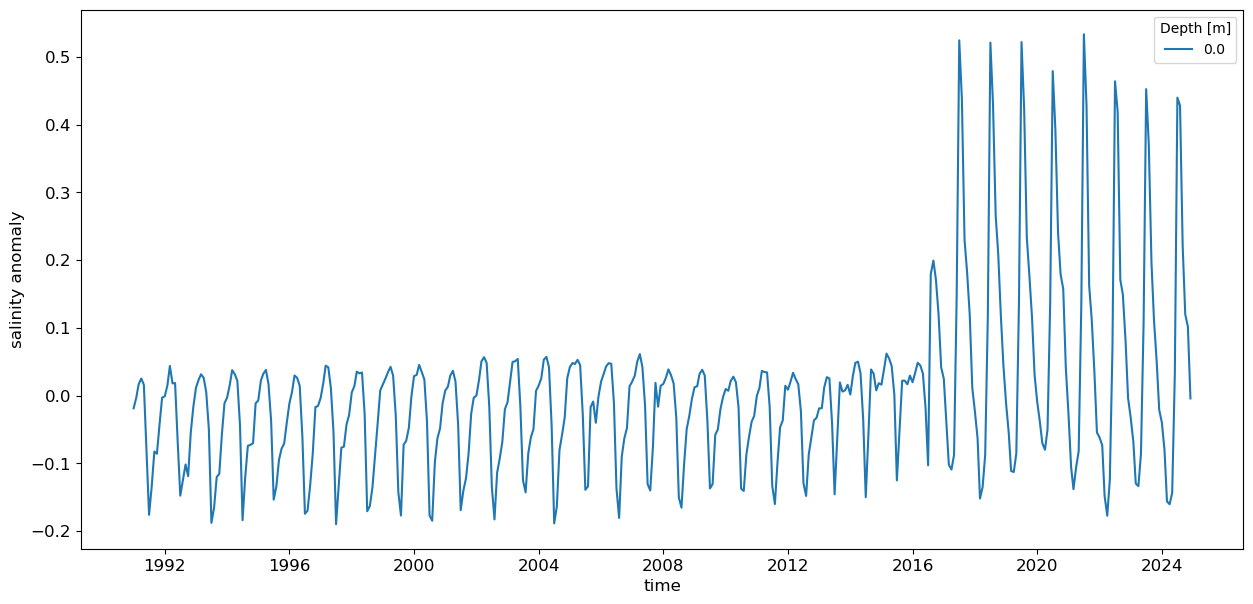

In [10]:
timeseriesplot(sal_tseries, "salinity", "time")
timeseriesplot(sal_clim_tseries, "salinity climatology", "month")
timeseriesplot(sal_anom_tseries, "salinity anomaly", "time")

## 3. Anomaly plots

In [11]:
oxy_pos_aoo_anom = timeseg(oxy_iso_anom, "time", ("1994-01-01", "1994-12-01"), Tstep="4mo")
oxy_neg_aoo_anom = timeseg(oxy_iso_anom, "time", ("2007-01-01", "2007-12-01"), Tstep="4mo")

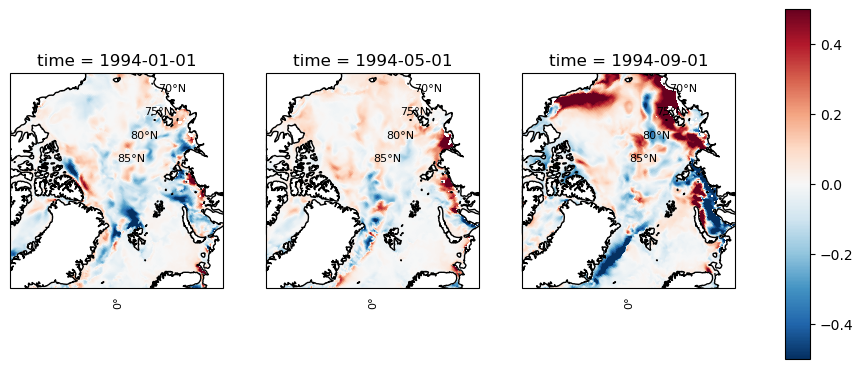

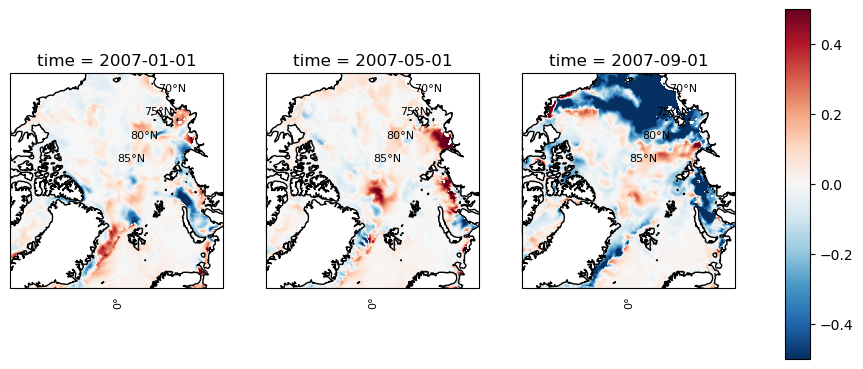

In [12]:
fig, ax, p = multiplot(oxy_pos_aoo_anom, ncol=3, nrow=1, vmin=-0.5, vmax=0.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))
fig, ax, p = multiplot(oxy_neg_aoo_anom, ncol=3, nrow=1, vmin=-0.5, vmax=0.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

## 4. AOO Index & Gradients

The AOO index measures the strength and direction (cyclonic or anticyclonic) of the wind driven circulation in the Arctic Ocean. It correlates strongly with the freshwater content in the Beaufort Gyre, which is centred on (150W, 75N) [Regan et. al., 2020].

Text(0, 0.5, 'AOO index')

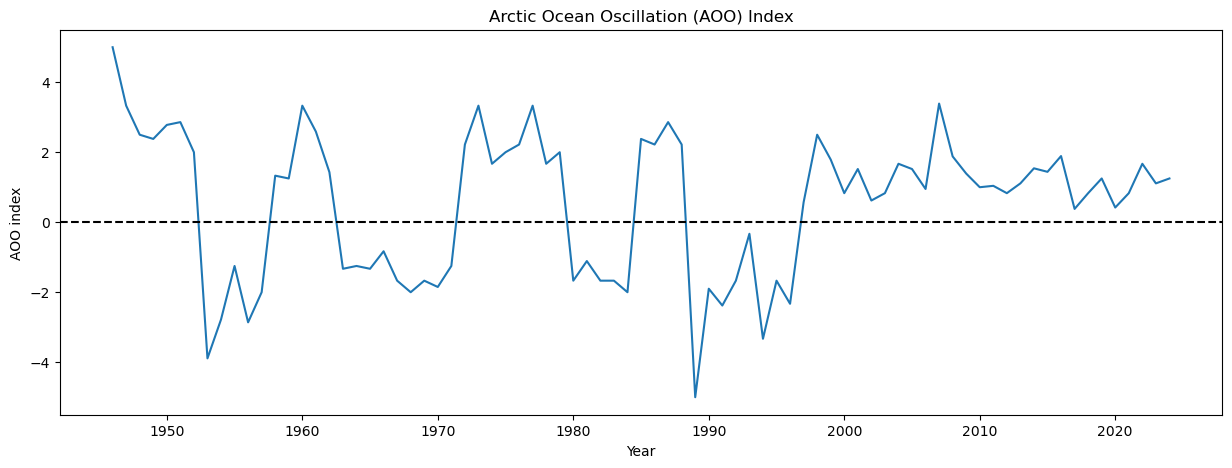

In [13]:
# Plot the AOO index (defined from the Beaufort Gyre Exploration Project)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(aoo_df["Year"], aoo_df["AOO Index"])
ax.axhline(0, color="k", linestyle="--")
ax.set_title("Arctic Ocean Oscillation (AOO) Index")
ax.set_xlabel("Year")
ax.set_ylabel("AOO index")

### 4.1. Gradients from North Pole

First, we consider oxygen isotope freshwater tracer gradients eminating from the North Pole - how does it compare to the AOO?

In [58]:
oxy_iso_da, lat_name, lon_name = oxy_iso_anom, "latitude", "longitude" 
# oxy_iso_da, lat_name, lon_name = oxy_iso_anom_rot, "lat_rot", "lon_rot"
oxy_anom_yr_lonav = timestep_da(xy_region(oxy_iso_da, lon_name, lat_name, False, (70,90)), "1y").mean(lon_name)

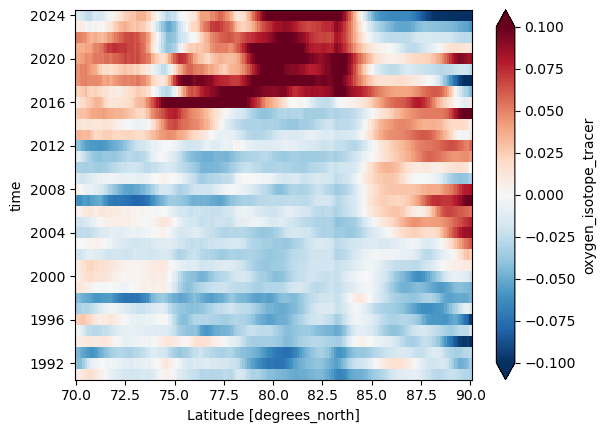

In [59]:
oxy_anom_yr_lonav.plot(vmin=-0.1, vmax=0.1, cmap="RdBu_r")

In [60]:
oxy_anom_yr_latgrad = (oxy_anom_yr_lonav - oxy_anom_yr_lonav.sel({lat_name:90}))

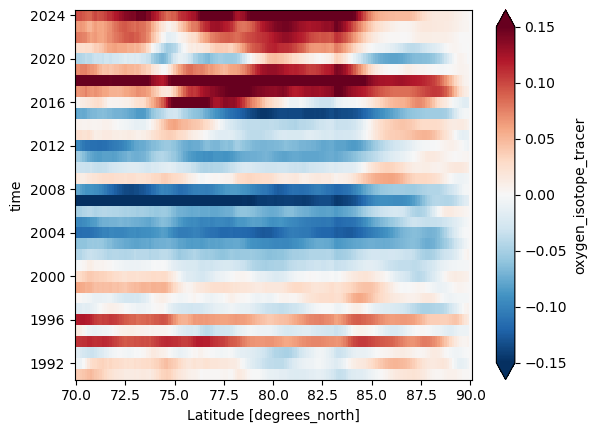

In [61]:
oxy_anom_yr_latgrad.plot(cmap="RdBu_r", vmin=-0.15, vmax=0.15)

In [62]:
oxy_anom_yr_grad = oxy_anom_yr_latgrad.mean(lat_name)

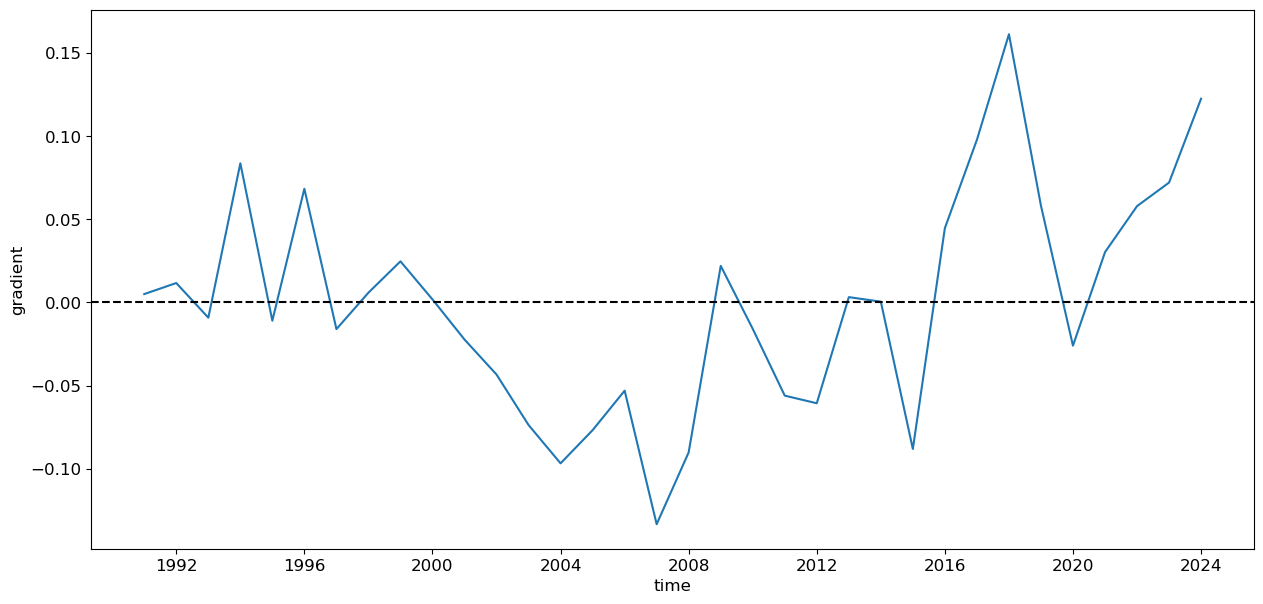

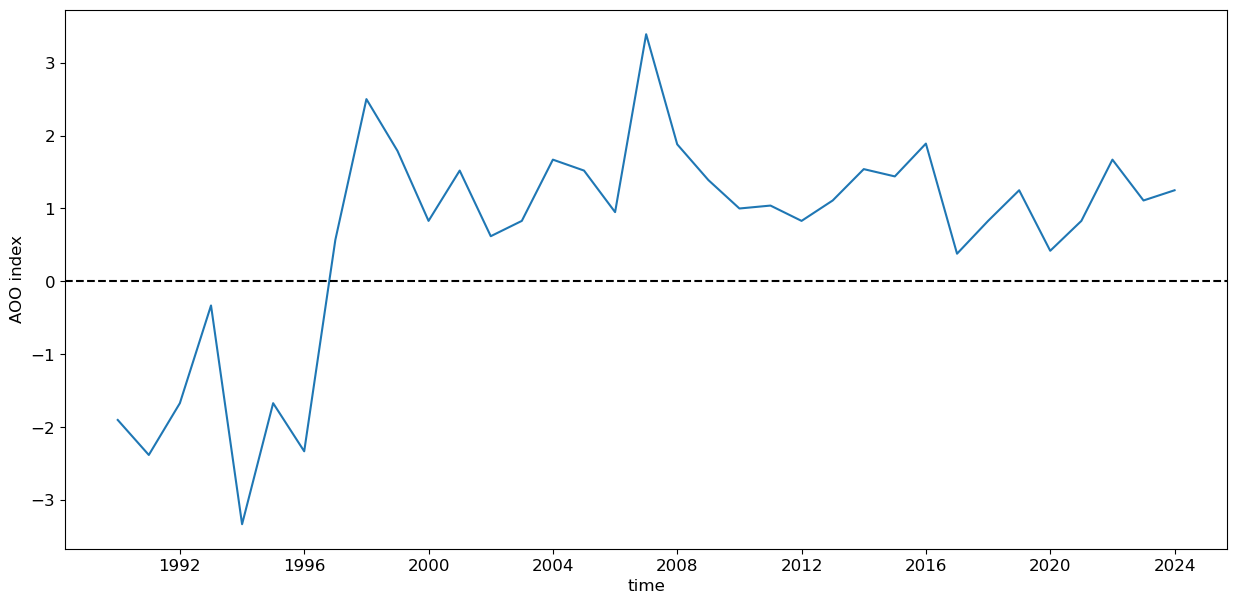

In [63]:
fig, ax1, pl = timeseriesplot(oxy_anom_yr_grad, "gradient", "time")
ax1.axhline(y=0, color="k", linestyle="--")

fig, ax2, pl = timeseriesplot(timeseg(aoo_da, "time", ("1990-01-01", "2024-01-01")), "AOO index", "time")
ax2.axhline(y=0, color="k", linestyle="--")


In [64]:
xr.corr(timeseg(aoo_da, "time", ("1990-01-01", "2024-01-01")), oxy_anom_yr_grad, "time")

<xarray.DataArray ()> Size: 8B
array(-0.32092583)

### 4.2. Rotating the pole to the centre of the Beaufort Gyre

To compare the oxygen freshwater tracer with the AOO index, we will consider the gradients from the centre of the Beaufort Gyre.

In [14]:
## Rotate pole function
def rotate_da(da, pole_lon, pole_lat, x="longitude", y="latitude"):
    """
    Rotate the pole of your DataArray
    
    Parameters
    ----------
    da : xarray.DataArray
        Input DataArray. Needs to be a global coordinate grid i.e. (-90, 90), (-180, 180)
    pole_lon, pole_lat : float
        Longitude and latitude of the new pole
    x, y : str
        Name of the longitude and latitude coordinates in the input DataArray
    """

    # Build rotated pole
    rotated_pole = ccrs.RotatedPole(pole_longitude=0, pole_latitude=pole_lat)

    # Define rotated coordinates
    ddeg = 0.125
    lon_rot = np.arange(-180, 180+ddeg, ddeg)
    lat_rot = np.arange(-90, 90+ddeg, ddeg)  # include 90° -> rotated pole
    lon2d_rot, lat2d_rot = np.meshgrid(lon_rot, lat_rot)

    # Transform rotated grid to geographic
    pts = ccrs.PlateCarree().transform_points(rotated_pole, lon2d_rot, lat2d_rot)
    lon_geo, lat_geo = pts[..., 0], pts[..., 1]

    # Shift to pole longitude & convert to [-180,180] range
    lon_geo_shifted = (lon_geo + pole_lon)
    lon_geo_shifted[lon_geo_shifted > 180] -= 360
    lon_geo_shifted[lon_geo_shifted < -180] += 360

    # Create the rotated grid
    rotated_grid = xr.Dataset({
        "lat": (('y','x'), lat_geo),
        "lon": (('y','x'), lon_geo_shifted)
    })

    # Regrid Arctic data
    regridder = xe.Regridder(da, rotated_grid, 
                            method='bilinear', periodic=True)
    da_rot = regridder(da)

    # Assign rotated coordinates properly
    da_rot = da_rot.assign_coords(
        lon_rot=(('x'), lon_rot),
        lat_rot=(('y'), lat_rot)
    )

    da_rot = da_rot.swap_dims({"x": "lon_rot", "y": "lat_rot"})

    return da_rot

In [15]:
oxy_iso_anom_rot = rotate_da(oxy_iso_anom, pole_lon=-150, pole_lat=75)

/noc/users/acable/miniforge3/envs/AISIT/lib/python3.13/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [16]:
# Check that it's worked properly! The pole of the new coordinates should match (150W, 75N) of the old coords, and lon_rot should be degenerate at 90N
print(oxy_iso_anom.isel(time=0).sel(longitude=-150, latitude=75).values)
print(oxy_iso_anom_rot.isel(time=0).sel(lat_rot=90).values)

-0.032469273
[-0.03246927 -0.03246927 -0.03246927 ... -0.03246927 -0.03246927
 -0.03246927]


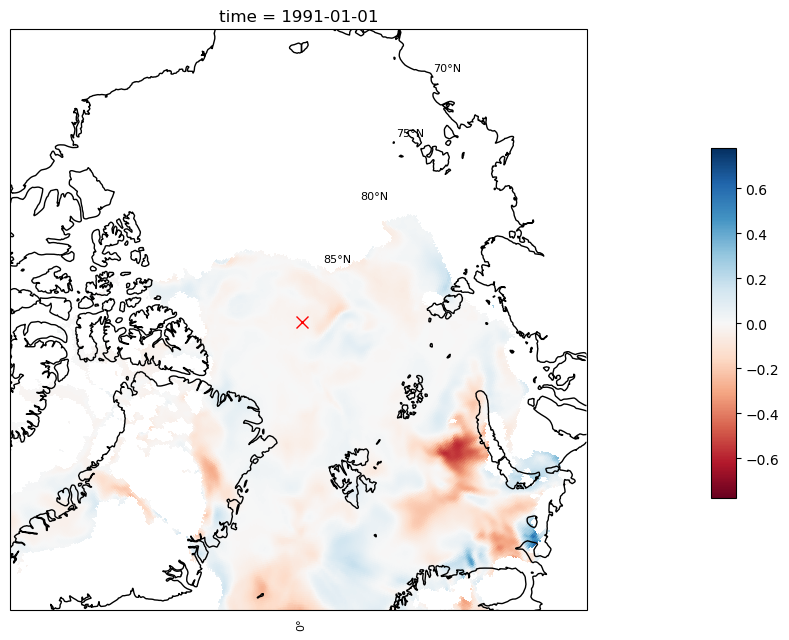

In [17]:

fig, ax, p = multiplot(oxy_iso_anom_rot.isel(time=0),map_type="NorthPolarStereo", xyreg=(False,(70,90)))
ax.plot(0, 90, 'rx', markersize=8, transform=ccrs.PlateCarree())

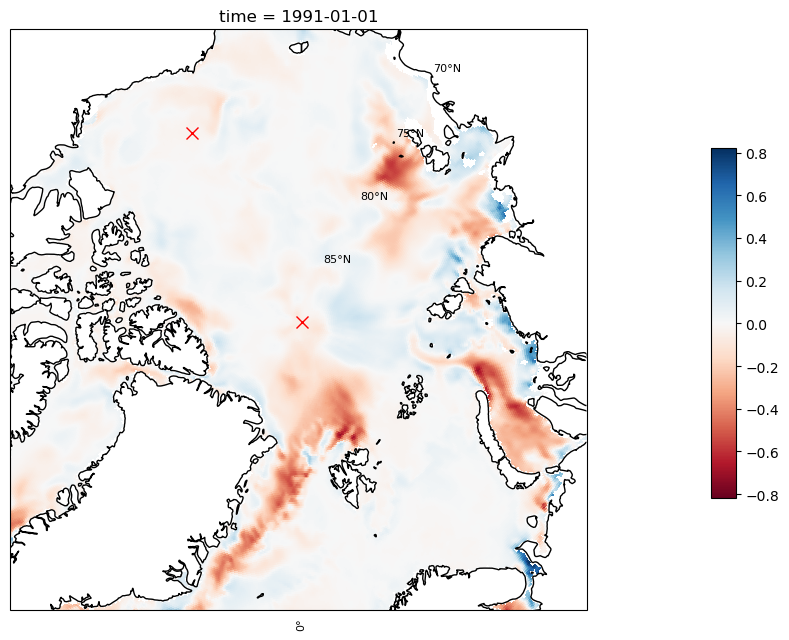

In [18]:
fig, ax, p = multiplot(oxy_iso_anom.isel(time=0),map_type="NorthPolarStereo", xyreg=(False,(70,90)))
ax.plot(-150, 75, 'rx', markersize=8, transform=ccrs.PlateCarree())
ax.plot(0, 90, 'rx', markersize=8, transform=ccrs.PlateCarree())

### 4.3. Gradients from North Pole & Beaufort Gyre centre

In [51]:
# oxy_iso_da, lat_name, lon_name = oxy_iso_anom, "latitude", "longitude" 
oxy_iso_da, lat_name, lon_name = oxy_iso_anom_rot, "lat_rot", "lon_rot"
oxy_anom_yr_lonav = timestep_da(xy_region(oxy_iso_da, lon_name, lat_name, False, (70,90)), "1y").mean(lon_name)

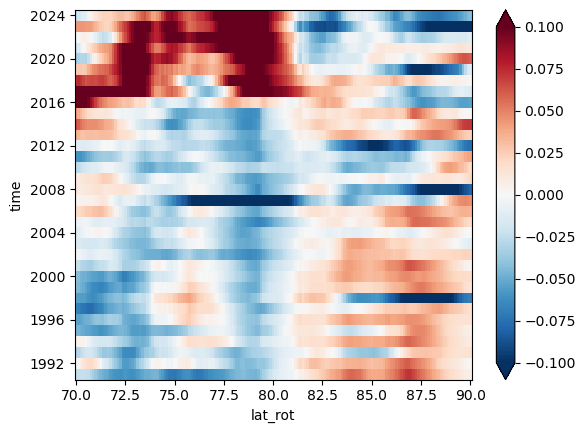

In [52]:
oxy_anom_yr_lonav.plot(vmin=-0.1, vmax=0.1, cmap="RdBu_r")

In [53]:
oxy_anom_yr_latgrad = (oxy_anom_yr_lonav - oxy_anom_yr_lonav.sel({lat_name:90}))

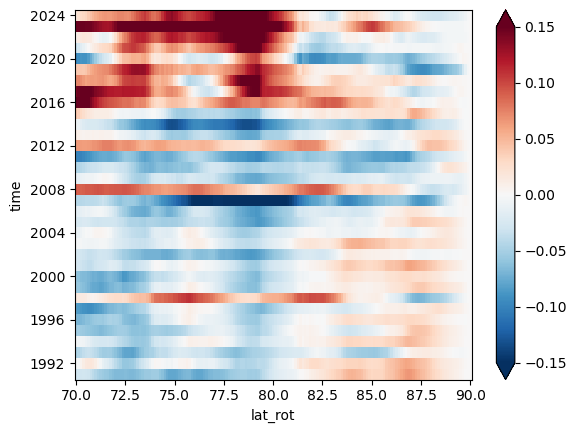

In [54]:
oxy_anom_yr_latgrad.plot(cmap="RdBu_r", vmin=-0.15, vmax=0.15)

In [55]:
oxy_anom_yr_grad = oxy_anom_yr_latgrad.mean(lat_name)

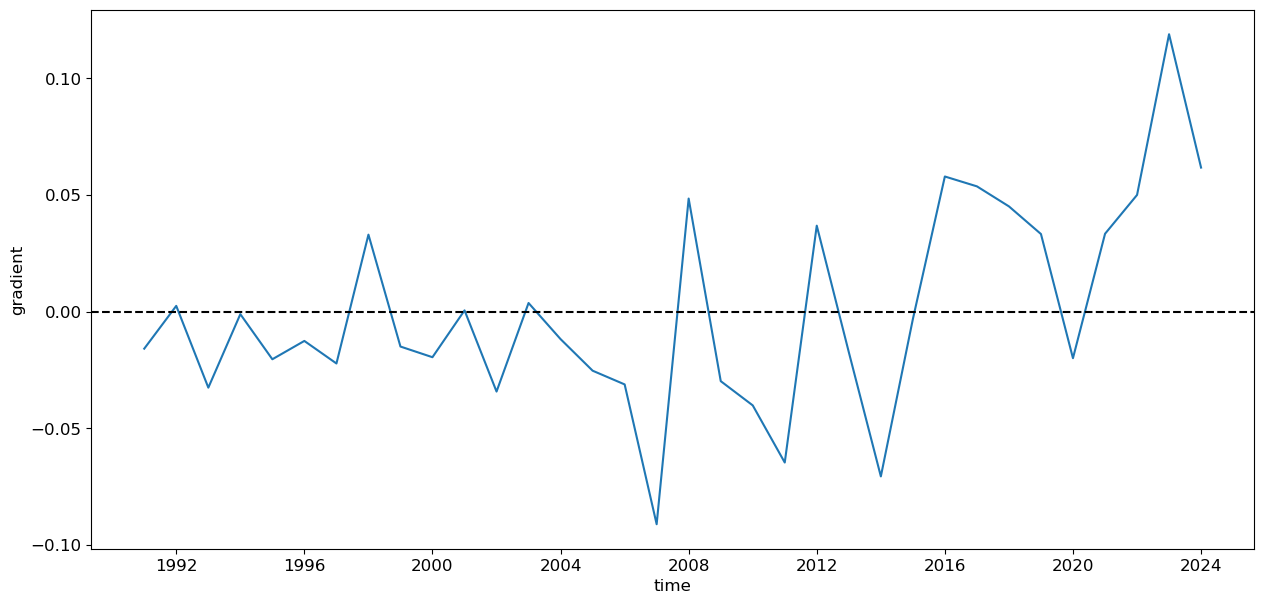

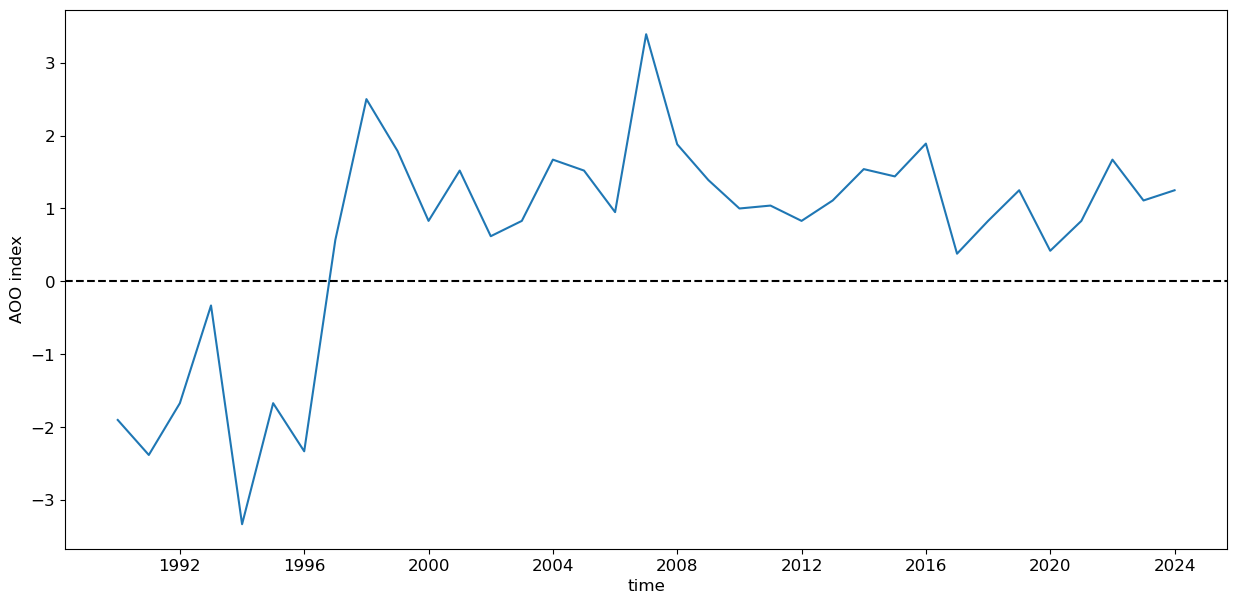

In [56]:
fig, ax1, pl = timeseriesplot(oxy_anom_yr_grad, "gradient", "time")
ax1.axhline(y=0, color="k", linestyle="--")

fig, ax2, pl = timeseriesplot(timeseg(aoo_da, "time", ("1990-01-01", "2024-01-01")), "AOO index", "time")
ax2.axhline(y=0, color="k", linestyle="--")


In [57]:
xr.corr(timeseg(aoo_da, "time", ("1990-01-01", "2024-01-01")), oxy_anom_yr_grad, "time")

<xarray.DataArray ()> Size: 8B
array(0.04121085)
Attributes:
    regrid_method:  bilinear